<a href="https://colab.research.google.com/github/Ndy-S/machine-learning-fundamental/blob/main/Sequences%2C%20Time%20Series%20and%20Prediction/W2_deep_nn_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Networks for Time Series

## Preparing Features and Labels

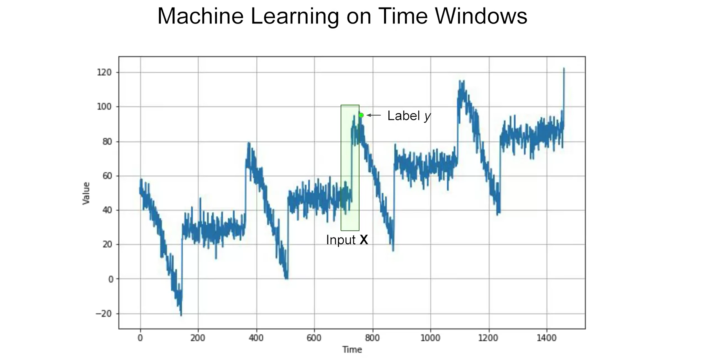

In [3]:
import tensorflow as tf

dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

for x, y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[4 5 6 7]
 [0 1 2 3]]
y =  [[8]
 [4]]
x =  [[3 4 5 6]
 [1 2 3 4]]
y =  [[7]
 [5]]
x =  [[2 3 4 5]
 [5 6 7 8]]
y =  [[6]
 [9]]


In [1]:
# SECTION DIVIDER

## Single Layer Neural Network Notebook Code

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:
      for series_num in series:
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()


def trend(time, slope=0):
    series = slope * time

    return series


def seasonal_pattern(season_time):
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    noise = rnd.randn(len(time)) * noise_level

    return noise

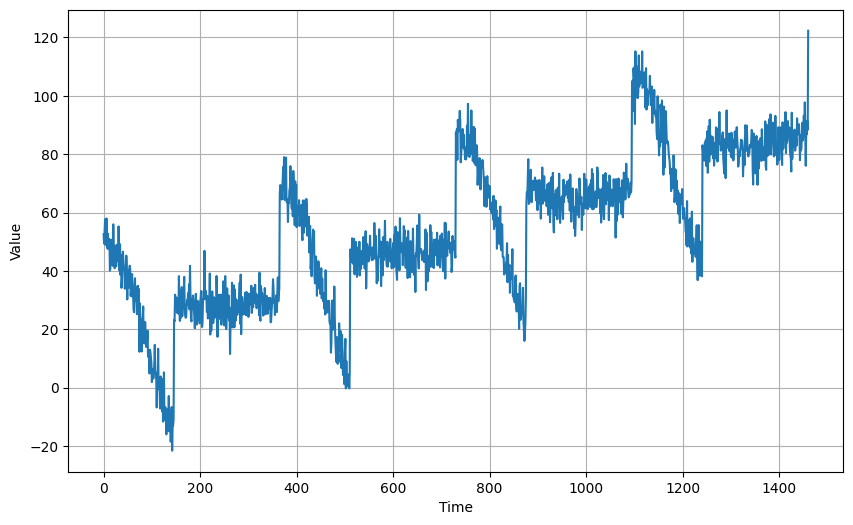

In [6]:
# Generate the synthetic data
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

series += noise(time, noise_level, seed=42)

plot_series(time, series)

In [8]:
# Split the dataset
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

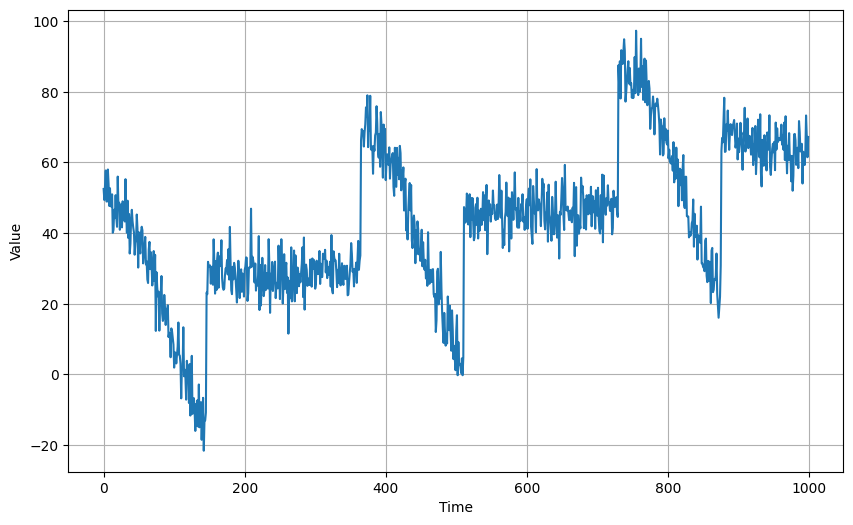

In [9]:
# Plot the train set
plot_series(time_train, x_train)

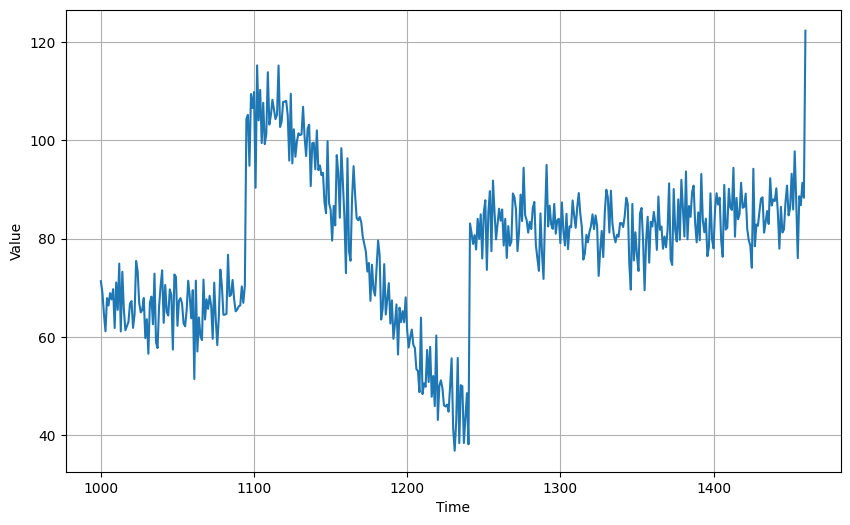

In [10]:
# Plot the validation set
plot_series(time_valid, x_valid)

In [11]:
# Prepare features and labels
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [13]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [14]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


In [15]:
# Build and compile the model
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

print("Layer weights: \n {} \n".format(l0.get_weights()))
model.summary()

Layer weights: 
 [array([[ 0.35841185],
       [ 0.52811545],
       [-0.26358205],
       [ 0.3995852 ],
       [-0.04779691],
       [ 0.29507238],
       [-0.32264873],
       [ 0.19252461],
       [-0.18473026],
       [ 0.12909174],
       [ 0.43040735],
       [-0.34365356],
       [-0.07877263],
       [ 0.02249753],
       [ 0.45038897],
       [-0.48631456],
       [-0.24490455],
       [-0.08828834],
       [-0.195207  ],
       [ 0.20087653]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [17]:
# Train the model
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 13ms/step - loss: 324.1356
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 223.9653
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 160.4312
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 126.2762
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 106.7377
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 95.5902
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 87.7948
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - loss: 83.4414
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 80.5348
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 78.1428
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 77.3235
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 74.7235
Epoch 13/100
31/31 

In [18]:
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.03358357],
       [ 0.04624961],
       [-0.06344111],
       [ 0.03447966],
       [-0.00347936],
       [ 0.06686163],
       [-0.08161887],
       [ 0.0371141 ],
       [-0.06231311],
       [ 0.05473318],
       [ 0.05666695],
       [-0.06992538],
       [-0.06857559],
       [ 0.05860075],
       [ 0.10948218],
       [-0.01361427],
       [ 0.0035495 ],
       [ 0.173984  ],
       [ 0.2620347 ],
       [ 0.46808895]], dtype=float32), array([0.01288748], dtype=float32)]


In [20]:
# Model prediction
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 22ms/step
model prediction: [[41.67871]]


In [21]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]

print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 [==============================] - 0s 32ms/step
length of the forecast list: 461
shape of the validation set: (461,)


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


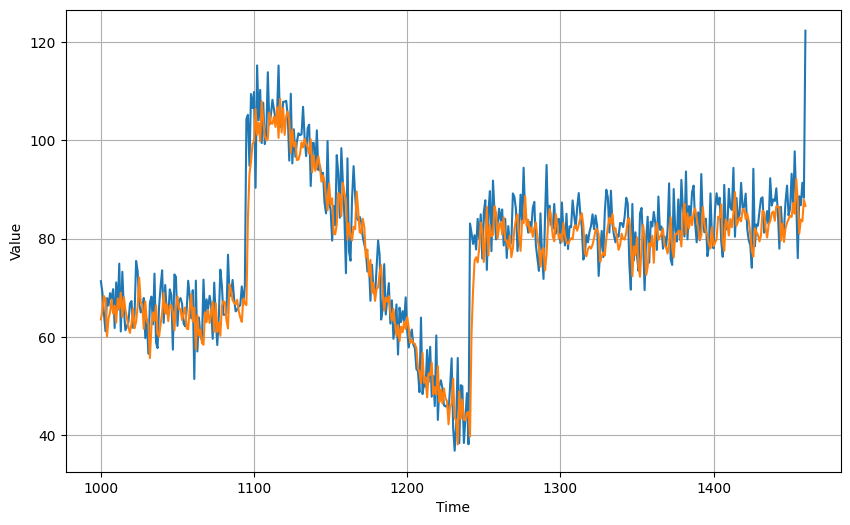

In [22]:
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

results = np.array(forecast).squeeze()

plot_series(time_valid, (x_valid, results))

In [23]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

50.675705
5.2387376


In [25]:
# SECTION DIVIDER

## Feeding Windowed Dataset Into Neural Network

In [24]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [ ]:
# SECTION DIVIDER

## Single Layer Neural Network

In [27]:
time = np.arange(4 * 365 + 1, dtype="float32")

In [28]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [30]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

In [32]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

In [33]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.01081889],
       [-0.01030819],
       [-0.00826016],
       [ 0.01228737],
       [ 0.05345916],
       [-0.01084012],
       [-0.03607799],
       [ 0.0419259 ],
       [-0.0269746 ],
       [ 0.00957731],
       [ 0.02309573],
       [ 0.02435002],
       [-0.04282425],
       [ 0.04073378],
       [ 0.01946589],
       [ 0.04803047],
       [ 0.04745841],
       [ 0.20832404],
       [ 0.26093912],
       [ 0.4138357 ]], dtype=float32), array([0.01664855], dtype=float32)]


In [34]:
# SECTION DIVIDER

## Prediction

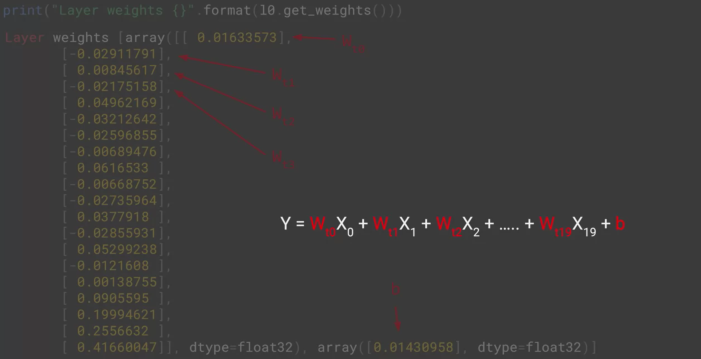

In [48]:
print(series[1:21])
model.predict(series[1:21][np.newaxis])

[49.35275  53.314735 57.711823 48.934444 48.931244 57.982895 53.897125
 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178 40.919415
 46.612473 44.228207 50.720642 44.454983 41.76799  55.980938]
1/1 [==============================] - 0s 34ms/step


array([[51.187756]], dtype=float32)

In [36]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 22ms/step


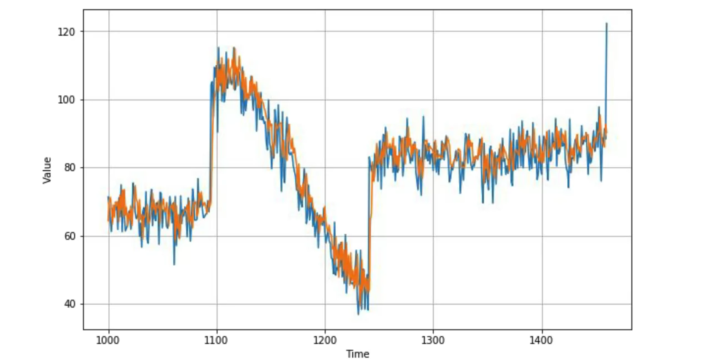

In [37]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.4097257

In [38]:
# SECTION DIVIDER

## Deep Neural Network Code

In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [51]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:
      for series_num in series:
        plt.plot(time[start:end], series_num[start:end], format)
    else:
      plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

def trend(time, slope=0):
    series = slope * time
    return series

def seasonal_pattern(season_time):
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    noise = rnd.randn(len(time)) * noise_level

    return noise

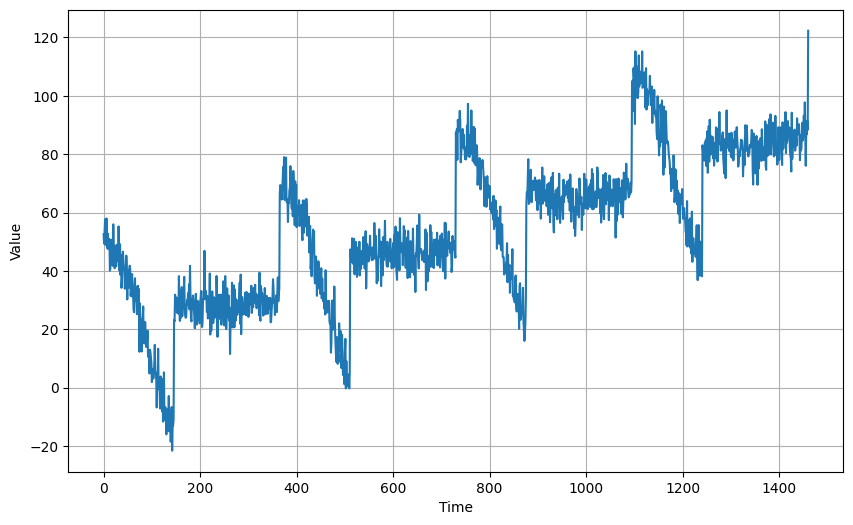

In [52]:
# Generate the synthetic data
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)
plot_series(time, series)

In [53]:
# Split the dataset
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [57]:
# Prepare features and labels
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [58]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [59]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [60]:
# Build the model
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model_baseline.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
# Set the training parameters
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [62]:
# Train the model
model_baseline.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 193.9615
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 76.2474
Epoch 3/100
31/31 [==============================] - 1s 4ms/step - loss: 68.9559
Epoch 4/100
31/31 [==============================] - 1s 6ms/step - loss: 67.2031
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 65.7253
Epoch 6/100
31/31 [==============================] - 1s 5ms/step - loss: 64.5256
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 63.7021
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 63.0972
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 62.1132
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 61.8926
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 60.5794
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 60.4005
Epoch 13/100
31/31 [====

1/1 [==============================] - 0s 32ms/step


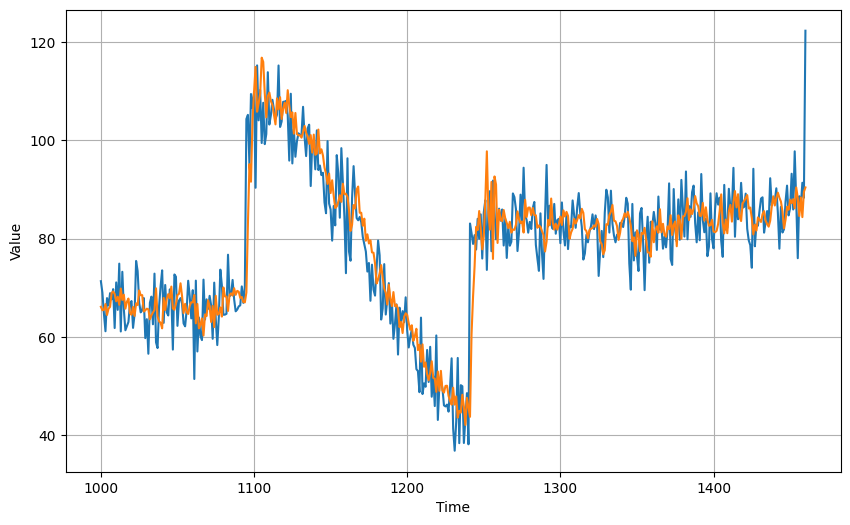

In [63]:
forecast = []

forecast_series = series[split_time - window_size:]

for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis]))

results = np.array(forecast).squeeze()

plot_series(time_valid, (x_valid, results))

In [64]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

45.289513
4.9390516


In [65]:
# Tune the learning rate
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [66]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [67]:
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model_tune.compile(loss="mse", optimizer=optimizer)

In [68]:
# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 19629.2793 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 9413.6836 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 5ms/step - loss: 5347.8608 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 3452.2866 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 2324.2341 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 1604.7980 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 1069.8247 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 682.8486 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 436.1711 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 306.1660 - lr: 2.8184e-08
E

(1e-08, 0.001, 0.0, 300.0)

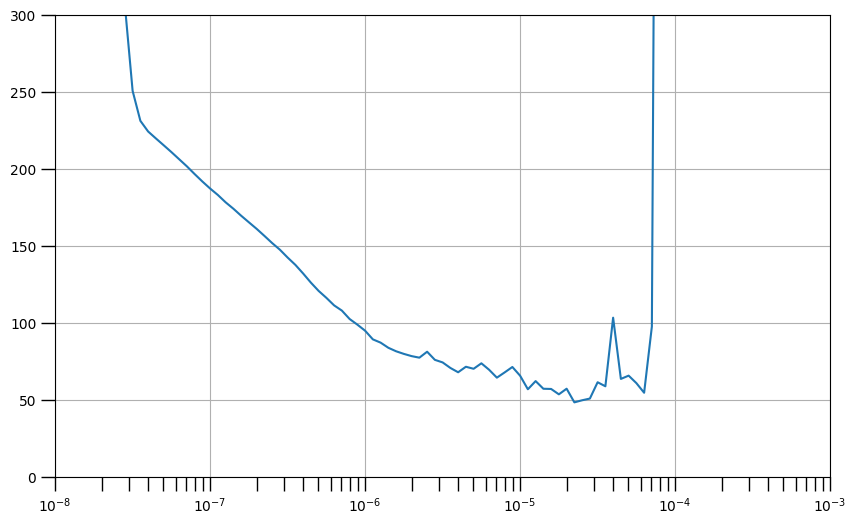

In [69]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 300])

In [70]:
# Build the model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [71]:
# Set the optimizer with the tuned learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)

In [72]:
# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 297.3936
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 86.4891
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 74.5128
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 70.3850
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 67.3328
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 64.5884
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 62.1103
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 60.4195
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 58.6599
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 57.4867
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 56.6255
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 55.5056
Epoch 13/100
31/31 [====

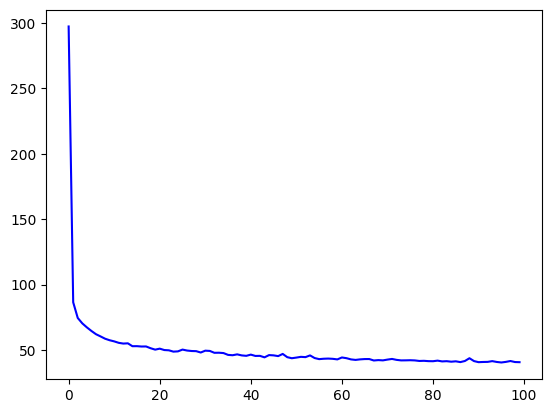

In [73]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

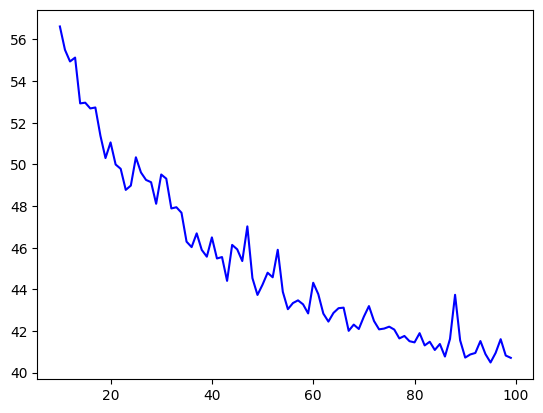

In [74]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

1/1 [==============================] - 0s 22ms/step


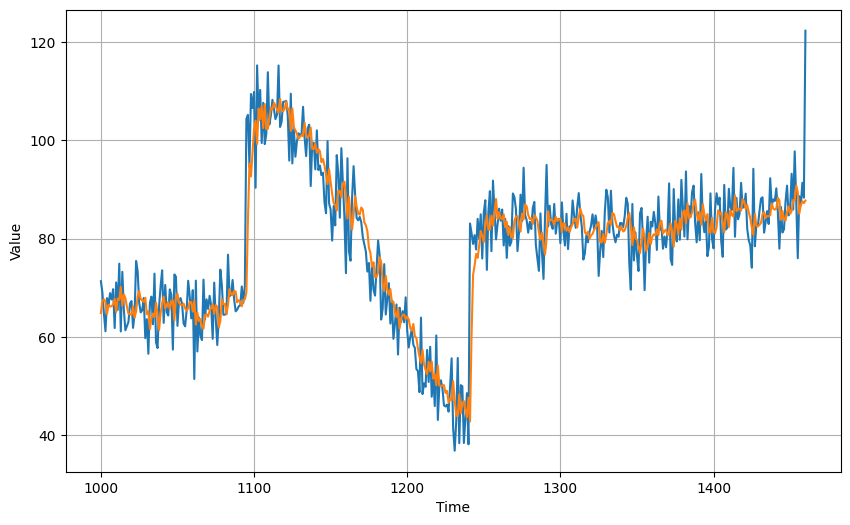

In [75]:
forecast = []

forecast_series = series[split_time - window_size:]

for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis]))

results = np.array(forecast).squeeze()
plot_series(time_valid, (x_valid, results))

In [76]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

42.49045
4.8135643


In [77]:
# SECTION DIVIDER

## Forecasting Using Neural Networks